# Task 2 – MLP, Learning rate, Overfitting, and Hyper-parameters.

### <span style="color:red">Deadline Tuesday, June 3, 2025 at 11:59 p.m<span>

# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to task02_[name].ipynb
- Only submit the ipynb file, no other file is required.
- The deadline is strict.
- Minimal requirement for passing: solving all code cells.

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells. Do not create additional cells. 

# Introduction

In this task you will implement an MLP model for virtual sensing using the flood dataset. 
The objectives are:
- Implementing an MLP model via TensorFlow Functional API.
- Getting more familiar with model fitting and overfitting.
- Implementing early stopping.
- Exploring hyperparameters and their influence.
- Selecting model architecture.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [Scikit-learn Tutorials](https://www.tensorflow.org/tutorials)
*   [TensorFlow Tutorials](https://scikit-learn.org/stable/tutorial/index.html)
*   [Matplotlib Tutorials](https://matplotlib.org/stable/tutorials/index.html)

## Imports

In [1]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 24
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## System checks


In [2]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices

In [3]:
tf.config.set_visible_devices(gpus, 'GPU')

# Subtask 2.1

## Backpropagation – Chain Rule

### Model
Let us assume an MLP with one hidden layer containing one neuron with `sigmoid` function ($S(x) = 1 / (1 + e^{-x})$) as the activation function. The input and the output dimensions are equal to one. The activation function for the input and output layers is `linear`.
The mapping $f: x \to \tilde{y}$ from the input $x$ to output $\tilde{y}$ can be written as:
\begin{equation}
\tilde{y} = f(x) = w_2 S(w_1 x)
\end{equation}
where $w_1$ and $w_2$ are the weights of the model. Note that we do not have bias for this example. Let us consider mean-squared error as the loss function. The loss $\ell$ can be obtained as:
\begin{equation}
\ell = (y - \tilde{y})^2 = (y - w_2 S(w_1 x))^2 
\end{equation}
where $y$ denotes the reference label. Let's initialize the weights as $w_1 = 0.1$ and $w_2 = 0.1$.

### Data

Let's assume we have a data set containing three samples as: $x = [1.0, 2.0, 3.0]^{T}$ and $y = [1.0, 4.0, 9.0]^{T}$.

#### TODO
 - Perform gradient descent by hand with a learning rate of 0.1. Train the model for 1 epoch with the batch size of 1.
 - Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [4]:
#<span style='color:red'>**Your answer:**</span>

"""

Iteration 1 :
        1. Forward pass :
            z1: w1*x = (1 * 0,1)  =  0.1
            s(z1) = 0.52
            y^=  0.1(1 /1+e**-(1 * 0,1) ) = 0.052 
            l = (y−y^) ** 2
            l(x1) = 0.81
        2. Backprobagation  :
            dldw2 = -2(y-y^)*S(w1x) = -2(1 - 0.52)(0.52) = 0.09949
            dldz1 = s(0.1)* (1- S(0.1)) = 0.2494
            dldw1 = -2(y-y^)* w2 *S(w1x) * (1- S(w1x)) * x = -2(0.9475) * (0.1) * (0.2494) * (1) = - 0.0473

        3. update weights :
            w1 = w1 - (learning rate * dldw1) = 0.1 - (0.1 * - 0.0473) = 0.10473
            w2 = w2 - (learning rate * dldw2) = 0.1 - (0.1 * - 0.9949) = 0.19949


Iteration 2 :
        1. Forward pass :
            z1: w1*x = (2 * 0,1047)  = 0.20946
            s(z1) = 0.5522
            y^=  0.19949(1 /1+e**-(2 * 0,1047) ) = 0.1102
            l(x2) =  15.1309

        2. Backprobagation  :
            dldw2 = -2(y-y^)*S(w1x) = -2(1 - 0.5522)(0.5522) = −4.2984
            dldz1 = s(0.20946)* (1- S(0.20946)) = 0.2474
            dldw1 = -2(y-y^)* w2 *S(w1x) * (1- S(w1x)) * x = -2(3.8898) * (0.19949) * (0.2474) * (2) = -0.7679

        3. update weights :
            w1 = w1 - (learning rate * dldw1) = 0.10473 - (0.1 * -0.7679) = 0.1815
            w2 = w2 - (learning rate * dldw2) = 0.19949 - (0.1 * -4.2984) = 0.62933




Iteration 3 :
        1. Forward pass :
            z1: w1*x = (3 * 0.1815)  = 0.5444
            s(z1) = 0.6328
            y^=  0.62933(1 /1+e**-(3 * 0.1815) ) = 0.3981
            l(x3) =  73.9928

        2. Backprobagation  :
            dldw2 = -2(y-y^)*S(w1x) = -2(9.0−0.3981)(0.6328) = -10.8873
            dldz1 = s(0.5444)* (1- S(0.5444)) = 0.2324
            dldw1 = -2(y-y^)* w2 *S(w1x) * (1- S(w1x)) * x = -2(8.4881) * (0.62933) * (0.2324) * (3) = -7.5437

        3. update weights :
            w1 = w1 - (learning rate * dldw1) = 0.1815 - (0.1 * -7.5437) = 0.9358
            w2 = w2 - (learning rate * dldw2) = 0.62933 - (0.1 * -10.8873) = 1.7178 




"""

'\n\nIteration 1 :\n        1. Forward pass :\n            z1: w1*x = (1 * 0,1)  =  0.1\n            s(z1) = 0.52\n            y^=  0.1(1 /1+e**-(1 * 0,1) ) = 0.052 \n            l = (y−y^) ** 2\n            l(x1) = 0.81\n        2. Backprobagation  :\n            dldw2 = -2(y-y^)*S(w1x) = -2(1 - 0.52)(0.52) = 0.09949\n            dldz1 = s(0.1)* (1- S(0.1)) = 0.2494\n            dldw1 = -2(y-y^)* w2 *S(w1x) * (1- S(w1x)) * x = -2(0.9475) * (0.1) * (0.2494) * (1) = - 0.0473\n\n        3. update weights :\n            w1 = w1 - (learning rate * dldw1) = 0.1 - (0.1 * - 0.0473) = 0.10473\n            w2 = w2 - (learning rate * dldw2) = 0.1 - (0.1 * - 0.9949) = 0.19949\n\n\nIteration 2 :\n        1. Forward pass :\n            z1: w1*x = (2 * 0,1047)  = 0.20946\n            s(z1) = 0.5522\n            y^=  0.19949(1 /1+e**-(2 * 0,1047) ) = 0.1102\n            l(x2) =  15.1309\n\n        2. Backprobagation  :\n            dldw2 = -2(y-y^)*S(w1x) = -2(1 - 0.5522)(0.5522) = −4.2984\n         

#### TODO
- Define two functions that compute the gradients of the loss with respect to $w_1$ and $w_2$ using analytical differentiation and chain rule.
- Use the functions you defined and train the model again using gradient descent and the same learning rate.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [5]:
####################
import numpy as np 

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradient_w1(x, y, w1, w2):
    """
    compute the gradient of l with respect to w1 
    dldw1 =  -2(y - ỹ) * w2 * S(w1*x) * (1 - S(w1*x)) * x
    """
    z1 = w1 * x
    sigmoid_z1 = sigmoid(z1)
    y_pred = w2 * sigmoid_z1

    dervative_sigmoid = sigmoid_z1 * (1 - sigmoid_z1)
    print(f"derivative of sigmoid: {dervative_sigmoid:.4f}")

    dldw1 = -2 * (y - y_pred) * w2 * sigmoid_z1 * (1 - sigmoid_z1) * x
    return dldw1

def gradient_w2(x, y, w1, w2):
    """ 
    compute the gradient of l with respect to w2
    dldw2 = -2(y - ỹ) * S(w1*x)
    """
    z1 = w1 * x 
    sigmoid_z1 = sigmoid(z1)
    y_pred = w2 * sigmoid_z1

    dldw2 = -2 * (y - y_pred) * sigmoid_z1
    return dldw2

# Data 

x = np.array([1.0, 2.0, 3.0])
y = np.array([1.0, 4.0, 9.0])

# Initial weights
w1 = 0.1
w2 = 0.1
learning_rate = 0.1

# some print statements

print(f"training with analytical gradients functions")
print (f"initial w2: {w2}, w1: {w2}")
print(f"learning rate: {learning_rate}")


for i, (xi, yi) in enumerate(zip(x,y)): 
    print(f"Iteration {i+1}: x = {xi}, y = {yi}")
    print(f" weights = w1: {w1:.4f}, w2: {w2:.4f}")



    # forward pass 
    z1 = w1 * xi
    print(f"z1: {z1:.4f}")
    sigmoid_z1 = sigmoid(z1)
    print(f"s(z1): {sigmoid_z1:.4f}")
    y_pred = w2 * sigmoid_z1
    loss = (yi - y_pred) ** 2

    # compute gradients using gradient_w2() and gradient_w1()
    dldw1 = gradient_w1(xi, yi, w1, w2)
    dldw2 = gradient_w2(xi, yi, w1, w2)

    print(f"predictiont y^: {y_pred:.4f}, loss: {loss:.4f}")
    print(f"gradients: dldw1: {dldw1:.4f}, dldw2: {dldw2:.4f}")

    # update weights
    w1 -= learning_rate * dldw1
    w2 -= learning_rate * dldw2
    print(f"updated w1: {w1:.4f}, w2: {w2:.4f}\n")



####################

training with analytical gradients functions
initial w2: 0.1, w1: 0.1
learning rate: 0.1
Iteration 1: x = 1.0, y = 1.0
 weights = w1: 0.1000, w2: 0.1000
z1: 0.1000
s(z1): 0.5250
derivative of sigmoid: 0.2494
predictiont y^: 0.0525, loss: 0.8978
gradients: dldw1: -0.0473, dldw2: -0.9948
updated w1: 0.1047, w2: 0.1995

Iteration 2: x = 2.0, y = 4.0
 weights = w1: 0.1047, w2: 0.1995
z1: 0.2095
s(z1): 0.5522
derivative of sigmoid: 0.2473
predictiont y^: 0.1101, loss: 15.1309
gradients: dldw1: -0.7675, dldw2: -4.2957
updated w1: 0.1815, w2: 0.6291

Iteration 3: x = 3.0, y = 9.0
 weights = w1: 0.1815, w2: 0.6291
z1: 0.5444
s(z1): 0.6328
derivative of sigmoid: 0.2324
predictiont y^: 0.3981, loss: 73.9928
gradients: dldw1: -7.5437, dldw2: -10.8873
updated w1: 0.9358, w2: 1.7178



#### TODO
- Use automatic differentiation (AD) (`tf.GradientTape`) to compute the gradients.
- Train the model again using the same learning rate, epoch, and batch size.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [6]:
####################
import tensorflow as tf
import numpy as np

# Data
x = np.array([1.0, 2.0, 3.0])
y = np.array([1.0, 4.0, 9.0])

# Initial weights as TensorFlow variables
w1 = tf.Variable(0.1, dtype=tf.float32)
w2 = tf.Variable(0.1, dtype=tf.float32)
learning_rate = 0.1

print("Training with TensorFlow automatic differentiation:")
print(f"Learning rate: {learning_rate}")
print(f"Initial weights: w1 = {w1.numpy()}, w2 = {w2.numpy()}")

# Train for 1 epoch with batch size 1
for i, (xi, yi) in enumerate(zip(x, y)):
    print(f"\nIteration {i+1}: x = {xi}, y = {yi}")
    
    xi_tf = tf.constant(xi, dtype=tf.float32)
    yi_tf = tf.constant(yi, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Forward pass
        z1 = w1 * xi_tf
        sigmoid_z1 = tf.sigmoid(z1)
        y_pred = w2 * sigmoid_z1
        loss = (yi_tf - y_pred)**2
    
    # Compute gradients using automatic differentiation
    gradients = tape.gradient(loss, [w1, w2])
    dL_dw1, dL_dw2 = gradients
    
    print(f"Prediction ỹ = {y_pred.numpy():.6f}")
    print(f"Loss = {loss.numpy():.6f}")
    print(f"Gradients: ∂ℓ/∂w1 = {dL_dw1.numpy():.6f}, ∂ℓ/∂w2 = {dL_dw2.numpy():.6f}")
    
    # Update weights
    w1_new = w1 - learning_rate * dL_dw1
    w2_new = w2 - learning_rate * dL_dw2
    
    print(f"Updated weights: w1 = {w1_new.numpy():.6f}, w2 = {w2_new.numpy():.6f}")
    
    # Apply updates
    w1.assign(w1_new)
    w2.assign(w2_new)
    ####################

Training with TensorFlow automatic differentiation:
Learning rate: 0.1
Initial weights: w1 = 0.10000000149011612, w2 = 0.10000000149011612

Iteration 1: x = 1.0, y = 1.0
Prediction ỹ = 0.052498
Loss = 0.897760
Gradients: ∂ℓ/∂w1 = -0.047257, ∂ℓ/∂w2 = -0.994838
Updated weights: w1 = 0.104726, w2 = 0.199484

Iteration 2: x = 2.0, y = 4.0
Prediction ỹ = 0.110149
Loss = 15.130939
Gradients: ∂ℓ/∂w1 = -0.767514, ∂ℓ/∂w2 = -4.295735
Updated weights: w1 = 0.181477, w2 = 0.629057

Iteration 3: x = 3.0, y = 9.0
Prediction ỹ = 0.398094
Loss = 73.992790
Gradients: ∂ℓ/∂w1 = -7.543694, ∂ℓ/∂w2 = -10.887305
Updated weights: w1 = 0.935846, w2 = 1.717788


2025-06-03 14:39:41.361221: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-06-03 14:39:41.361255: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-03 14:39:41.361260: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-03 14:39:41.361284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-03 14:39:41.361299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Subtask 2.2

In this task, we consider the data from **Margarethenklippe** as the input and train an MLP that gives the information about **Sennhuette** as the output. For each of the sensors, we have the water level, **W**, and the mass flow rate, **Q**, every 15 minutes.
## Pre-processing 

#### TODO
 - Load the flood dataset (`Flood_Data.csv`) using *pandas* library.
 - Drop the first four columns of the DataFrame and columns containing NaNs.
 - Split the data into inputs and outputs.
 - Shuffle the data and get the NumPy arrays.
 - Split the data to 75% for training, 15% for validation, and 15% for testing.
 - Standardize inputs and outputs. 
 

In [7]:
# TODO load the flood dataset using pandas

####################
df = pd.read_csv('flood_data.csv', sep=';')
print (df.head(), df.shape)

#df.columns.tolist()

df = df.drop(df.columns[:4], axis=1)  # Drop the first four columns
print (f" \ndf after droping the first 4 columns {df}")


print("\nDropping columns with NaN values...")
df = df.dropna(axis =1)
print(f"\ndf after droping NaN columns: {df} \nFinal shape after dropping NaN columns: {df.shape}")

df.head()





####################

        Datum      Zeit   GranetalsperreMin15Niederschlag  \
0  01.11.2003  00:15:00                               0.0   
1  01.11.2003  00:30:00                               0.0   
2  01.11.2003  00:45:00                               0.0   
3  01.11.2003  01:00:00                               0.0   
4  01.11.2003  01:15:00                               0.0   

    HahnenkleeMin15Niederschlag   MargarethenklippeMin15W  \
0                           0.0                       7.3   
1                           0.0                       7.3   
2                           0.0                       7.2   
3                           0.0                       7.2   
4                           0.0                       7.2   

    MargarethenklippeMin15Q   SennhuetteMin15W   SennhuetteMin15Q  Unnamed: 8  
0                  0.037909                4.4           0.031730         NaN  
1                  0.037909                4.3           0.030458         NaN  
2                  0.03672

,MargarethenklippeMin15W,MargarethenklippeMin15Q,SennhuetteMin15W,SennhuetteMin15Q
0,7.3,0.037909,4.4,0.031730
1,7.3,0.037909,4.3,0.030458
2,7.2,0.036720,4.4,0.031730
3,7.2,0.036720,4.5,0.033025
4,7.2,0.036720,4.4,0.031730


In [8]:
# TODO split the data into inputs X and outputs y
####################
X = df.iloc[:, :2].values # First 2 columns (Margarethenklippe W and Q)
y = df.iloc[:, 2:].values # Remaining columns (Sennhuette W and Q)
####################

N_samples = X.shape[0] # number of samples
N_samples, X.shape, y.shape

(514176, (514176, 2), (514176, 2))

In [9]:
# TODO shuffle the data and get the NumPy arrays:
####################
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=SEED)
print(f"X shape: {X.shape}, y shape: {y.shape}")
####################

# TODO split the data to train, validation, and test:
####################
train_size = int(N_samples * 0.75) # train size
val_size = int(N_samples * 0.15) # validation size
test_size = N_samples - train_size - val_size # test size


print (f"train size: {train_size}, {train_size/N_samples:.2%} of the data")
print (f"validation size: {val_size}, {val_size/N_samples:.2%} of the data")
print (f"test size: {test_size}, {test_size/N_samples:.2%} of the data")


# Split the data
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]
####################

X shape: (514176, 2), y shape: (514176, 2)
train size: 385632, 75.00% of the data
validation size: 77126, 15.00% of the data
test size: 51418, 10.00% of the data


Let us define a class for standardizing the data. We will implement a function that applies the scaling (`apply`) and a function that maps the scaled data back into the original scale (`apply_reverse`). 

In [10]:
# TODO create a class for standardizing the data.

####################

class StandardScaler:
    def __init__(self):
        self.mean = None 
        self.std = None 
    
    def fit(self, data):
        # compute mean and std of the data 

        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return self.mean, self.std
    
    def apply(self, data): #This is equivalent to sklearn's transform() method
        # apply standardization (data - mean) / std
        if self.mean is None or self.std is None:
            raise ValueError("Scaler must be fitted before applying")
        return (data - self.mean) / self.std
    
    def apply_reverse(self, scaled_data):
        # reverse the standardization
        if self.mean is None or self.std is None:
            raise ValueError("Scaler must be fitted before applying reverse transformation")
        return (scaled_data * self.std) + self.mean
####################

In [11]:
# TODO standardize the data using the class you defined in the cell above.

####################
# Create scalers for inputs and outputs
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scalers on the training data ONLY!
scaler_X.fit(X_train)
scaler_y.fit(y_train)

# Apply the scalers to the training, validation, and test data

X_train_scaled = scaler_X.apply(X_train)
X_val_scaled = scaler_X.apply(X_val)
X_test_scaled = scaler_X.apply(X_test)

y_train_scaled = scaler_y.apply(y_train)
y_val_scaled = scaler_y.apply(y_val)
y_test_scaled = scaler_y.apply(y_test)

print("Data standardization completed")

# Verify standardization
print(f"\nOriginal X_train stats:")
print(f"  Mean: {np.mean(X_train, axis=0)}")
print(f"  Std:  {np.std(X_train, axis=0)}")

print(f"\nStandardized X_train stats:")
print(f"  Mean: {np.mean(X_train_scaled, axis=0)}")
print(f"  Std:  {np.std(X_train_scaled, axis=0)}")

print(f"\nOriginal y_train stats:")
print(f"  Mean: {np.mean(y_train, axis=0)}")
print(f"  Std:  {np.std(y_train, axis=0)}")

print(f"\nStandardized y_train stats:")
print(f"  Mean: {np.mean(y_train_scaled, axis=0)}")
print(f"  Std:  {np.std(y_train_scaled, axis=0)}")
#a,b = scaler_y.fit(y_train)
#a,b



####################

Data standardization completed

Original X_train stats:
  Mean: [10.39186429  0.12313528]
  Std:  [5.84790603 0.20412646]

Standardized X_train stats:
  Mean: [5.88427220e-14 5.74990004e-14]
  Std:  [1. 1.]

Original y_train stats:
  Mean: [7.97057041 0.10807751]
  Std:  [6.2627399  0.19941676]

Standardized y_train stats:
  Mean: [-2.37570816e-14  5.26834649e-14]
  Std:  [1. 1.]


# Subtask 2.3

## Implementing an MLP using TensorFlow Functional API.

#### TODO

- Implement an MLP using TensorFlow Functional API. 
- Print the model architecture using `model.summary()`.

In [12]:
# TODO implement the model 



####################
def MLP(N_hidden_layers, N_neurons, activation):
    input_layer = layers.Input(shape = (2,))
    x = input_layer
    for i in range(N_hidden_layers):
        x = layers.Dense(N_neurons, activation=activation, name = f"hidden_{i+1}")(x)
    output_layer = layers.Dense(2, activation='linear', name='output')(x)  # Linear activation for regression tasks

    #creating the model
    model = models.Model(inputs = input_layer, outputs = output_layer)
    return model

model = MLP(
    N_hidden_layers=2,  # Number of hidden layers
    N_neurons=64,       # Number of neurons in each hidden layer
    activation='relu'  # Activation function for hidden layers
)
####################




In [13]:
# TODO print the model architecture
####################
print("MODEL ARCHITECTURE:")

model.summary()
####################

MODEL ARCHITECTURE:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,482 (17.51 KB)

 Trainable params: 4,482 (17.51 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def new_LR(LR, epochs):
    #tf.keras.backend,clear_session()
    model_name = MLP(N_hidden_layers=2, N_neurons=128, activation="relu") 
    optimizer = optimizers.SGD(learning_rate=LR)
    loss_fn = losses.MeanSquaredError()
    model_name.compile(optimizer=optimizer, loss=loss_fn)
    print("Training the model ---")

    history = model_name.fit(
        X_train,
        y_train,
        epochs = epochs,
        batch_size = 512,
        validation_data = (X_val, y_val),
        verbose = 2 
                        
    )


    return model_name, history

# Subtask 2.4

## Optimizer, loss function and training

#### TODO

- Define the optimizer and the loss function using `tf.keras.optimizers` and `tf.keras.losses`, respectively. 
    - Use stochastic gradient descent (SGD) with a learning rate of 1.0 as the optimizer.
    - Use mean-squared error as the loss function.
- Compile the model using the optimizer and the loss.
- Train the model and get the history of training and validation losses.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the learning curves.

In [16]:
# TODO define the optimizer and the loss function
####################

# Define SGD optimizer with learning rate 1.0
optimizer = optimizers.SGD(learning_rate=1.0) #1.0 isnt this too high?
print("Optimizer SGD LR=1.0")
print(f"   Type: {type(optimizer).__name__}")
print(f"   Learning rate: {optimizer.learning_rate.numpy()}")

loss_function = losses.MeanSquaredError() # Mean Squared Error for regression tasks


####################

# TODO compile the model
####################

model.compile(optimizer = optimizer, loss = loss_function)


# Display compilation details
#print(f"\nCompiled model details:")
#print(f"- Optimizer: {model.optimizer.__class__.__name__}")
#print(f"- Loss: {model.loss}")
#print(f"- Metrics: {model.metrics_names}")


####################

Optimizer SGD LR=1.0
   Type: SGD
   Learning rate: 1.0


In [17]:
# TODO train the model 
####################
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 10, # Number of epochs
          batch_size = 512, # Batch size
          validation_data = (X_val_scaled, y_val_scaled),
          verbose = 1 # Verbosity mode, to show progress during training
          )

####################

Epoch 1/10


2025-06-03 14:40:34.130833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: nan - val_loss: nan
Epoch 2/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - val_loss: nan
Epoch 3/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: nan - val_loss: nan
Epoch 4/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: nan - val_loss: nan
Epoch 5/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - val_loss: nan
Epoch 6/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: nan - val_loss: nan
Epoch 7/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - val_loss: nan
Epoch 9/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - val_loss: nan
Epoch 10/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: nan - val_loss: nan


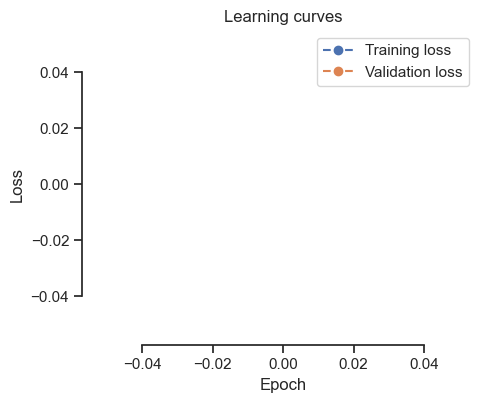

In [18]:

def plot_learning_curves(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    ax.plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--')
    ax.plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Learning curves')
    ax.legend()
    sns.despine(trim=True, offset=5)

# TODO Use the function above to plot the learning curves
####################
plot_learning_curves(history)
####################

**TODO Your answer here**

Does the model learn properly? Why?


**TODO Your answer here**

<span style='color:red'>**Your answer: 
No, this happens beause we set the learning rate very high to 1.0. This causes gradient to become extremley large during backprobogation which lead to very big weight updates, so it could grow to psivitive or negative infinity ----> mathematical operations producing NaN values
**</span>

...


# Subtask 2.5

## Learning rate

#### TODO
- Decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the training curves of the loss and the accuracies as in Subtask 1.3. Use the function defined above.


Training the model ---
Epoch 1/10
754/754 - 5s - 6ms/step - loss: nan - val_loss: nan
Epoch 2/10
754/754 - 5s - 6ms/step - loss: nan - val_loss: nan
Epoch 3/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 4/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 5/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 6/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 7/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 9/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 10/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan


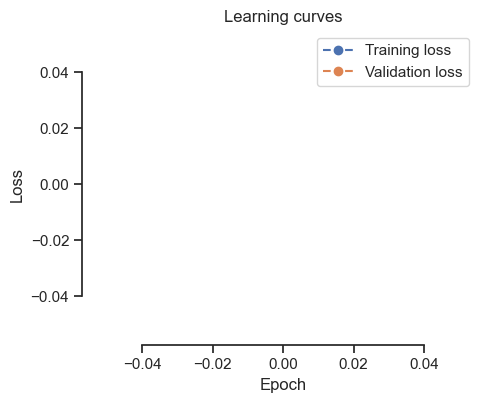

In [41]:
#tf.keras.backend.clear_session() # Clear the session to free up resources

# learning rate = 0.1
model , history = new_LR(0.1, 10)
plot_learning_curves(history)
####################


Training the model ---
Epoch 1/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 2/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 3/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 4/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 5/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 6/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 7/10
754/754 - 4s - 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
754/754 - 5s - 6ms/step - loss: nan - val_loss: nan
Epoch 9/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan
Epoch 10/10
754/754 - 4s - 5ms/step - loss: nan - val_loss: nan


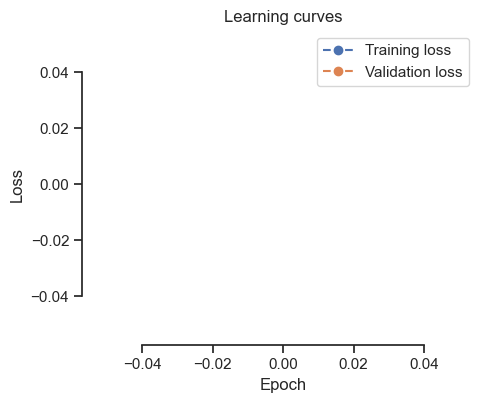

In [42]:
#tf.keras.backend.clear_session() # Clear the session to free up resources

# learning rate = 0.01
####################

model , history = new_LR(0.01, 10)
plot_learning_curves(history)

####################

Training the model ---
Epoch 1/10
754/754 - 5s - 6ms/step - loss: 1.5909 - val_loss: 1.3433
Epoch 2/10
754/754 - 5s - 6ms/step - loss: 1.1062 - val_loss: 1.1418
Epoch 3/10
754/754 - 5s - 7ms/step - loss: 0.9933 - val_loss: 1.1354
Epoch 4/10
754/754 - 4s - 6ms/step - loss: 0.9828 - val_loss: 1.1315
Epoch 5/10
754/754 - 4s - 5ms/step - loss: 0.9804 - val_loss: 1.1249
Epoch 6/10
754/754 - 4s - 5ms/step - loss: 0.9784 - val_loss: 1.1180
Epoch 7/10
754/754 - 4s - 5ms/step - loss: 0.9764 - val_loss: 1.1115
Epoch 8/10
754/754 - 4s - 5ms/step - loss: 0.9747 - val_loss: 1.1067
Epoch 9/10
754/754 - 4s - 5ms/step - loss: 0.9731 - val_loss: 1.1007
Epoch 10/10
754/754 - 4s - 5ms/step - loss: 0.9716 - val_loss: 1.0967


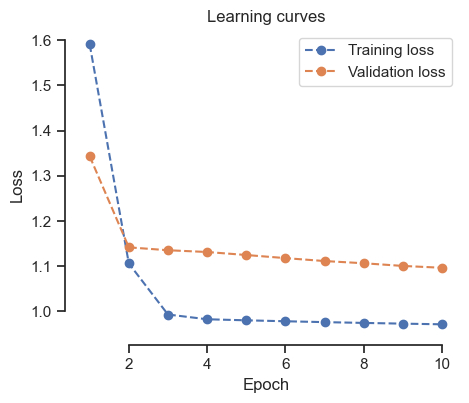

In [43]:
#tf.keras.backend.clear_session() # Clear the session to free up resources

# learning rate = 0.001

model , history = new_LR(0.001, 10)
plot_learning_curves(history)
####################

Training the model ---
Epoch 1/10
754/754 - 4s - 6ms/step - loss: 2.5470 - val_loss: 1.9960
Epoch 2/10
754/754 - 4s - 5ms/step - loss: 1.8905 - val_loss: 1.9018
Epoch 3/10
754/754 - 4s - 5ms/step - loss: 1.8015 - val_loss: 1.8147
Epoch 4/10
754/754 - 4s - 5ms/step - loss: 1.7190 - val_loss: 1.7335
Epoch 5/10
754/754 - 4s - 5ms/step - loss: 1.6416 - val_loss: 1.6567
Epoch 6/10
754/754 - 4s - 5ms/step - loss: 1.5687 - val_loss: 1.5846
Epoch 7/10
754/754 - 4s - 5ms/step - loss: 1.5004 - val_loss: 1.5168
Epoch 8/10
754/754 - 4s - 6ms/step - loss: 1.4364 - val_loss: 1.4532
Epoch 9/10
754/754 - 4s - 5ms/step - loss: 1.3767 - val_loss: 1.3939
Epoch 10/10
754/754 - 4s - 5ms/step - loss: 1.3214 - val_loss: 1.3390


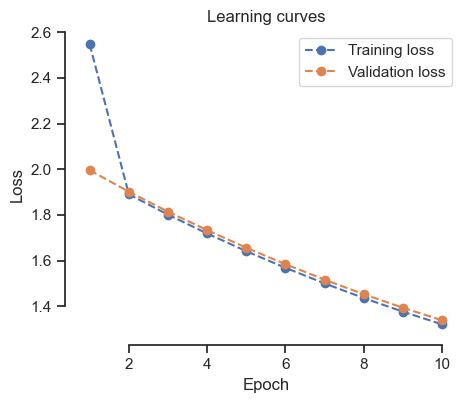

In [44]:
#tf.keras.backend.clear_session() # Clear the session to free up resources

# learning rate = 1e-4

model , history = new_LR(0.0001, 10)
plot_learning_curves(history)
####################

## Model selection

Is it the lowest validation loss that one can achieve? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs and plot the learning curves. Use learning rate of 0.01.

#### TODO from now on, for all subsequent tasks:
- Print the overall best validation loss and the epoch at which it occurred of.


Training the model ---
Epoch 1/100
754/754 - 5s - 6ms/step - loss: 1.7716 - val_loss: 1.4553
Epoch 2/100
754/754 - 4s - 5ms/step - loss: 1.1910 - val_loss: 1.1830
Epoch 3/100
754/754 - 4s - 5ms/step - loss: 1.0121 - val_loss: 1.1400
Epoch 4/100
754/754 - 4s - 5ms/step - loss: 0.9812 - val_loss: 1.1401
Epoch 5/100
754/754 - 4s - 5ms/step - loss: 0.9777 - val_loss: 1.1368
Epoch 6/100
754/754 - 4s - 6ms/step - loss: 0.9762 - val_loss: 1.1320
Epoch 7/100
754/754 - 4s - 5ms/step - loss: 0.9748 - val_loss: 1.1270
Epoch 8/100
754/754 - 4s - 5ms/step - loss: 0.9735 - val_loss: 1.1222
Epoch 9/100
754/754 - 4s - 5ms/step - loss: 0.9722 - val_loss: 1.1179
Epoch 10/100
754/754 - 4s - 5ms/step - loss: 0.9711 - val_loss: 1.1138
Epoch 11/100
754/754 - 4s - 5ms/step - loss: 0.9701 - val_loss: 1.1100
Epoch 12/100
754/754 - 4s - 5ms/step - loss: 0.9691 - val_loss: 1.1064
Epoch 13/100
754/754 - 4s - 6ms/step - loss: 0.9681 - val_loss: 1.1030
Epoch 14/100
754/754 - 4s - 5ms/step - loss: 0.9673 - val_loss:

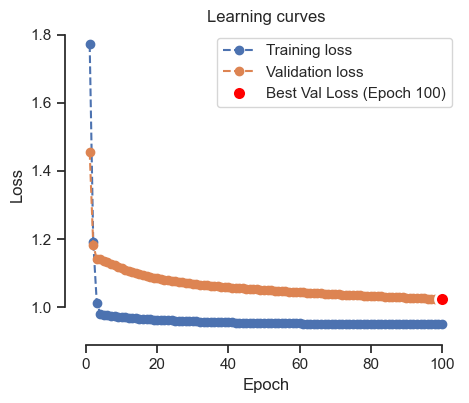

In [45]:
####################
#tf.keras.backend.clear_session() # Clear the session to free up resources

model , history = new_LR(0.001, 100)

def plot_learning_curves1(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    ax.plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--')
    ax.plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--')

    # Mark best epoch
    best_epoch_idx = np.argmin(hist.history['val_loss'])
    best_val_loss = np.min(hist.history['val_loss'])
    ax.plot(best_epoch_idx + 1, best_val_loss, 'ro', markersize=10, 
            markerfacecolor='red', markeredgecolor='white', markeredgewidth=2,
            label=f'Best Val Loss (Epoch {best_epoch_idx + 1})')
    

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Learning curves')
    ax.legend()
    sns.despine(trim=True, offset=5)

plot_learning_curves1(history)
########################################

**TODO Your answer here**

Answer the following questions in written form:

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

**TODO Your answer here**


<span style='color:red'>**Your answer:

1. The training loss generally decreases after each epoch, but not The training loss generally decreases after each epoch, but not necessarily monotonically, It decreases because the optimizer (SGD) adjusts the model weights based on gradients to minimize the loss function on the training data
 monotonically
2. The validation loss does not decrease monotonically after each epoch, at the begening, it decreases faster becuase the model learns generalizable patterns from the traninig data, and they typically fluctuate more than traning loss. They eventually reach a minimum before they increase again. this happens beacuse the model start overfitting. 
3. The model was best at the epoch where validation loss reached its minimum (see plot).  After this point, in this case after 100 epochs, the model likely begins overfitting - if we keep improving on training data while getting worse on validation data, indicating it's memorizing training specific patterns rather than learning to generelize.

**</span>



# Subtask 2.6
## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk.
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Evaluate `model2` on the validation dataset.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation loss again. It should be of the exact same value as `model`'s validation loss.


*Hints:*
 - Read https://www.tensorflow.org/tutorials/keras/save_and_load
 - Use `model.save_weights`

In [50]:
####################
checkpoint_path = "model_checkpoint.weights.h5"
model.save_weights(checkpoint_path)
current_val_loss = model.evaluate(X_val_scaled, y_val_scaled, verbose=0)
current_val_loss

####################


5.485382080078125

# Subtask 2.7
## Early stopping
So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.

### TODO
- Implement Early Stopping using `tf.keras.callbacks.EarlyStopping`. Use patience = 5, which means that if the validation loss is not improved after 5 epochs, the training process should be stopped.
- Save the model checkpoint after each epoch if the validation loss is improved. Use `tf.keras.callbacks.ModelCheckpoint`.
- Train the model for 100 epochs with a learning rate of 0.01.
- Load the model checkpoint.
- Evaluate the model on the validation data.

In [ ]:
####################
## YOUR CODE HERE ##
####################


In [ ]:
## TODO load the model checkpoint and evaluate on validation data
####################
## YOUR CODE HERE ##
####################

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- What is the purpose of `patience`, and why do we need that?
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

In [ ]:
####################
## YOUR CODE HERE ##
####################

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 1024 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 (from above) and 1024 
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [ ]:
# Batch size 1024

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

# Subtask 2.8
## What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of hidden layers
- number of neurons per each hidden layer
- activation function 

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [ ]:
# number of hidden layers

####################
## YOUR CODE HERE ##
####################

# 4 hidden layers

In [ ]:
# number of neurons per each hidden layer

####################
## YOUR CODE HERE ##
####################

# 100 neurons

In [ ]:
# activation function

####################
## YOUR CODE HERE ##
####################

# Use tanh instead of ReLU

**TODO Your answer here**

1. How good do you get?
2. Which hyper-parameter makes the largest difference?
3. Does it always help to make your model bigger (i.e. wider / deeper)? Why not?

**TODO Your answer here**


**Your answers:**
1. ...

# Subtask 2.9
## Challenge
#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?

In [ ]:
# Your best model:

####################
## YOUR CODE HERE ##
####################

# Subtask 2.10
## Evaluate your best model on test set, once!
When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- Evaluate the model on the testing dataset.
- Plot the reference mass flow rate vs. the predicted values for the first 50 samples of the testing dataset.

In [ ]:
# TODO evaluate the model
####################
## YOUR CODE HERE ##
####################


In [ ]:
# TODO plot results
####################
## YOUR CODE HERE ##
####################

y_pred = ...


**TODO Your answer here**

1. Is the test loss of your model as good as the validation loss?
2. If those values are different: How can you explain the difference?
3. Why should you never use test set performance when trying out different hyper-parameters and architectures?

**TODO Your answer here**



<span style='color:red'>**Your answer:**</span>

1. ...